#### Import modules

In [1]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import pickle

### States

#### Read states data file

In [2]:
states_adj = {}

with open(os.getcwd() + '/Data/usa-state-data.json', 'r') as state_json:
    states_adj = json.load(state_json)
    
len(states_adj)

51

In [3]:
# states_adj

#### Create states code and name maps

In [4]:
code_to_name, name_to_code = {}, {}

for code in states_adj:
    name = states_adj[code]['name']
    code_to_name[code] = name
    name_to_code[name] = code
    
code_to_name['MA'], name_to_code['Massachusetts']

('Massachusetts', 'MA')

In [5]:
def write_pickle(file, obj) -> None:
    """Write an object to a pickle file
    Parameters:
        file (str): file path
        obj (Any): object to write
    Returns:
        None"""
    
    with open(file, 'wb') as pckl:
        pickle.dump(obj, pckl, pickle.HIGHEST_PROTOCOL)
        
    pckl.close()

In [6]:
write_pickle(os.getcwd() + '/Data/code_to_name.pickle', code_to_name)

In [7]:
write_pickle(os.getcwd() + '/Data/name_to_code.pickle', name_to_code)

#### Create network of states

In [8]:
ignore_states = ()

state_cons = []

for s in states_adj:
    if s not in ignore_states:
        for n in states_adj[s]['adjacent']:  # lists for AK and HI are empty, hence this loop is not run for them
            state_cons.append([s, n, states_adj[s]['region'], states_adj[n]['region']])

In [9]:
# state_cons

In [10]:
states_edge_pairs = pd.DataFrame(state_cons, columns = ['state1', 'state2', 'state1_region', 'state2_region'])
states_edge_pairs['same_region'] = states_edge_pairs['state1_region'] == states_edge_pairs['state2_region'] 
states_edge_pairs.head()

,state1,state2,state1_region,state2_region,same_region
0,AL,FL,South,South,True
1,AL,GA,South,South,True
2,AL,TN,South,South,True
3,AL,MS,South,South,True
4,AZ,NM,West,West,True


In [11]:
states_regions = states_edge_pairs[['state1', 'state1_region']].drop_duplicates().set_index('state1')
states_regions.head()

,state1_region
state1,
AL,South
AZ,West
AR,South
CA,West
CO,West


In [12]:
states_graph = nx.from_pandas_edgelist(states_edge_pairs, 'state1', 'state2', ['same_region'])
nx.set_node_attributes(states_graph, values = states_regions['state1_region'].to_dict(), name = 'Region')

In [13]:
states_graph.nodes['MA']['Region']

'Northeast'

In [14]:
states_graph['MA']

AtlasView({'CT': {'same_region': True}, 'NH': {'same_region': True}, 'VT': {'same_region': True}, 'NY': {'same_region': True}, 'RI': {'same_region': True}})

In [15]:
states_graph.number_of_nodes(), states_graph.number_of_edges()

(49, 107)

#### Write GML

In [16]:
nx.write_gml(states_graph, os.getcwd() + '/Graphs/states_graph.gml')

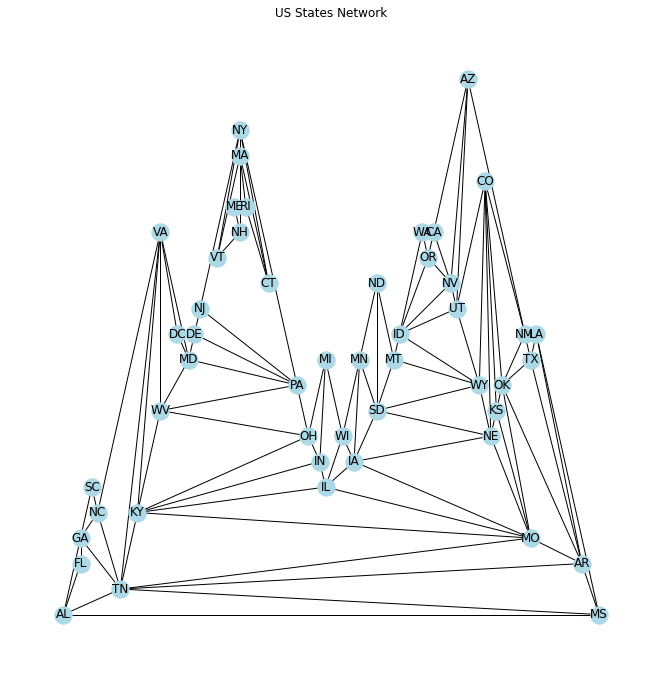

In [17]:
fig = plt.figure(figsize = (9, 9))
nx.draw_planar(states_graph, node_color = '#add8e6', with_labels = True)
plt.title('US States Network')
plt.show()
plt.close()

### Counties

#### Read counties data file

In [18]:
counties = pd.read_csv(os.getcwd() + '/Data/county_adjacency.csv')  # file missing two counties in countyname column: 'Otter Tail County, MN', 'Watonwan County, MN'
counties.shape

(22200, 4)

In [19]:
counties.head()

,countyname,fipscounty,neighborname,fipsneighbor
0,"Autauga County, AL",1001,"Autauga County, AL",1001
1,"Autauga County, AL",1001,"Chilton County, AL",1021
2,"Autauga County, AL",1001,"Dallas County, AL",1047
3,"Autauga County, AL",1001,"Elmore County, AL",1051
4,"Autauga County, AL",1001,"Lowndes County, AL",1085


#### Preprocessing

Row 9441 has incorrect FIPS code (found when looking for neighbours of the missing Otter Tail county)

In [20]:
counties[counties['neighborname'] == 'Otter Tail County, MN']

,countyname,fipscounty,neighborname,fipsneighbor
9084,"Becker County, MN",27005,"Otter Tail County, MN",27111
9160,"Clay County, MN",27027,"Otter Tail County, MN",27111
9204,"Douglas County, MN",27041,"Otter Tail County, MN",27111
9240,"Grant County, MN",27051,"Otter Tail County, MN",27111
9441,"Todd County, MN",27111,"Otter Tail County, MN",27111
9590,"Todd County, MN",27153,"Otter Tail County, MN",27111
9610,"Wadena County, MN",27159,"Otter Tail County, MN",27111
9636,"Wilkin County, MN",27167,"Otter Tail County, MN",27111


In [21]:
counties.loc[9441, 'fipscounty'] = 27153
counties[counties['neighborname'] == 'Otter Tail County, MN']

,countyname,fipscounty,neighborname,fipsneighbor
9084,"Becker County, MN",27005,"Otter Tail County, MN",27111
9160,"Clay County, MN",27027,"Otter Tail County, MN",27111
9204,"Douglas County, MN",27041,"Otter Tail County, MN",27111
9240,"Grant County, MN",27051,"Otter Tail County, MN",27111
9441,"Todd County, MN",27153,"Otter Tail County, MN",27111
9590,"Todd County, MN",27153,"Otter Tail County, MN",27111
9610,"Wadena County, MN",27159,"Otter Tail County, MN",27111
9636,"Wilkin County, MN",27167,"Otter Tail County, MN",27111


Since the graph will be made using nx.Graph, repeated edges do not matter

In [22]:
otter_tail_mn = counties.loc[counties['neighborname'] == 'Otter Tail County, MN'].reset_index(drop = True).rename(columns = {'countyname': 'neighborname', 'fipscounty': 'fipsneighbor', 'neighborname': 'countyname', 'fipsneighbor': 'fipscounty'})[['countyname', 'fipscounty', 'neighborname', 'fipsneighbor']]
otter_tail_mn

,countyname,fipscounty,neighborname,fipsneighbor
0,"Otter Tail County, MN",27111,"Becker County, MN",27005
1,"Otter Tail County, MN",27111,"Clay County, MN",27027
2,"Otter Tail County, MN",27111,"Douglas County, MN",27041
3,"Otter Tail County, MN",27111,"Grant County, MN",27051
4,"Otter Tail County, MN",27111,"Todd County, MN",27153
5,"Otter Tail County, MN",27111,"Todd County, MN",27153
6,"Otter Tail County, MN",27111,"Wadena County, MN",27159
7,"Otter Tail County, MN",27111,"Wilkin County, MN",27167


Some Washington County, MN rows have incorrect FIPS code (found when looking for neighbours of the other missing county - Wantonwan)

In [23]:
counties[counties['neighborname'] == 'Watonwan County, MN']

,countyname,fipscounty,neighborname,fipsneighbor
9115,"Blue Earth County, MN",27013,"Watonwan County, MN",27165
9122,"Brown County, MN",27015,"Watonwan County, MN",27165
9182,"Cottonwood County, MN",27033,"Watonwan County, MN",27165
9286,"Jackson County, MN",27063,"Watonwan County, MN",27165
9372,"Martin County, MN",27091,"Watonwan County, MN",27165
9633,"Washington County, MN",27165,"Watonwan County, MN",27165


In [24]:
counties.loc[(counties['countyname'] == 'Washington County, MN') & (counties['fipscounty'] == 27165), 'fipscounty'] = 27163
counties[counties['countyname'] == 'Washington County, MN']

,countyname,fipscounty,neighborname,fipsneighbor
9620,"Washington County, MN",27163,"Anoka County, MN",27003
9621,"Washington County, MN",27163,"Chisago County, MN",27025
9622,"Washington County, MN",27163,"Dakota County, MN",27037
9623,"Washington County, MN",27163,"Ramsey County, MN",27123
9624,"Washington County, MN",27163,"Washington County, MN",27163
9625,"Washington County, MN",27163,"Pierce County, WI",55093
9626,"Washington County, MN",27163,"Polk County, WI",55095
9627,"Washington County, MN",27163,"St. Croix County, WI",55109
9628,"Washington County, MN",27163,"Blue Earth County, MN",27013
9629,"Washington County, MN",27163,"Brown County, MN",27015


In [25]:
wantonwan_mn = counties.loc[counties['neighborname'] == 'Watonwan County, MN'].reset_index(drop = True).rename(columns = {'countyname': 'neighborname', 'fipscounty': 'fipsneighbor', 'neighborname': 'countyname', 'fipsneighbor': 'fipscounty'})[['countyname', 'fipscounty', 'neighborname', 'fipsneighbor']]
wantonwan_mn

,countyname,fipscounty,neighborname,fipsneighbor
0,"Watonwan County, MN",27165,"Blue Earth County, MN",27013
1,"Watonwan County, MN",27165,"Brown County, MN",27015
2,"Watonwan County, MN",27165,"Cottonwood County, MN",27033
3,"Watonwan County, MN",27165,"Jackson County, MN",27063
4,"Watonwan County, MN",27165,"Martin County, MN",27091
5,"Watonwan County, MN",27165,"Washington County, MN",27163


In [26]:
counties = pd.concat([counties, otter_tail_mn, wantonwan_mn]).reset_index(drop = True)
counties.shape

(22214, 4)

In [27]:
counties.head()

,countyname,fipscounty,neighborname,fipsneighbor
0,"Autauga County, AL",1001,"Autauga County, AL",1001
1,"Autauga County, AL",1001,"Chilton County, AL",1021
2,"Autauga County, AL",1001,"Dallas County, AL",1047
3,"Autauga County, AL",1001,"Elmore County, AL",1051
4,"Autauga County, AL",1001,"Lowndes County, AL",1085


Get states and regions of counties

In [28]:
counties['county_state'] = counties['countyname'].apply(lambda x: x.split(',')[-1].strip())
counties['neighb_state'] = counties['neighborname'].apply(lambda x: x.split(',')[-1].strip())

counties = counties.set_index('county_state').join(states_regions).reset_index().rename(columns = {'index': 'county_state', 'state1_region': 'county_region'}).set_index('neighb_state').join(states_regions).reset_index().rename(columns = {'index': 'neighb_state', 'state1_region': 'neighb_region'})

In [29]:
exclude = ['AK', 'HI', 'AS', 'GU', 'MP', 'PR', 'VI']

counties = counties[~counties['county_state'].isin(exclude)].reset_index(drop = True)
counties.shape

(21597, 8)

In [30]:
counties = counties[['countyname', 'county_state', 'county_region', 'fipscounty', 'neighborname', 'neighb_state', 'neighb_region', 'fipsneighbor']]  # rearragne columns

counties['same_state'] = counties['county_state'] == counties['neighb_state']
counties['same_region'] = counties['county_region'] == counties['neighb_region']

counties.head()

,countyname,county_state,county_region,fipscounty,neighborname,neighb_state,neighb_region,fipsneighbor,same_state,same_region
0,"Autauga County, AL",AL,South,1001,"Autauga County, AL",AL,South,1001,True,True
1,"Autauga County, AL",AL,South,1001,"Chilton County, AL",AL,South,1021,True,True
2,"Autauga County, AL",AL,South,1001,"Dallas County, AL",AL,South,1047,True,True
3,"Autauga County, AL",AL,South,1001,"Elmore County, AL",AL,South,1051,True,True
4,"Autauga County, AL",AL,South,1001,"Lowndes County, AL",AL,South,1085,True,True


#### Create network of counties

In [31]:
counties_graph = nx.from_pandas_edgelist(counties, 'countyname', 'neighborname', ['same_state', 'same_region'])
nx.set_node_attributes(counties_graph, values = counties[['countyname', 'county_state']].drop_duplicates().set_index('countyname').to_dict()['county_state'], name = 'State')
nx.set_node_attributes(counties_graph, values = counties[['countyname', 'county_region']].drop_duplicates().set_index('countyname')['county_region'].to_dict(), name = 'Region')

In [32]:
counties_graph.nodes['Suffolk County, MA']

{'State': 'MA', 'Region': 'Northeast'}

In [33]:
counties_graph['Suffolk County, MA']

AtlasView({'Essex County, MA': {'same_state': True, 'same_region': True}, 'Middlesex County, MA': {'same_state': True, 'same_region': True}, 'Norfolk County, MA': {'same_state': True, 'same_region': True}, 'Plymouth County, MA': {'same_state': True, 'same_region': True}, 'Suffolk County, MA': {'same_state': True, 'same_region': True}})

In [34]:
counties_graph.number_of_nodes(), counties_graph.number_of_edges()

(3109, 12354)

Remove self loops

In [35]:
counties_graph.remove_edges_from(nx.selfloop_edges(counties_graph))

counties_graph.number_of_nodes(), counties_graph.number_of_edges()

(3109, 9247)

In [36]:
counties_graph['Suffolk County, MA']

AtlasView({'Essex County, MA': {'same_state': True, 'same_region': True}, 'Middlesex County, MA': {'same_state': True, 'same_region': True}, 'Norfolk County, MA': {'same_state': True, 'same_region': True}, 'Plymouth County, MA': {'same_state': True, 'same_region': True}})

#### Write GML

In [37]:
nx.write_gml(counties_graph, os.getcwd() + '/Graphs/counties_graph.gml')